# SURGE HACKATHON
    2019-03-10
    EEG / BCI hackathon

### AUTHORS
    Lindsey Power
    Matthew Smith
    Sanket Kumar Singh
    Ryan Amaral
    Ming Scott
    Elizabeth Coish
    

In [61]:
import mne
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
mne.set_log_level(verbose='error')

In [25]:
subject = 'beth_motor_imagery_2009-03-09'

In [26]:
event_id = {'OVTK_StimulationId_BaselineStart':1, 'OVTK_StimulationId_Beep':2,
       'OVTK_StimulationId_BaselineStop':3, 'OVTK_GDF_Start_Of_Trial':4,
       'OVTK_GDF_Cross_On_Screen':5, 'OVTK_GDF_Right':6,
       'OVTK_GDF_Feedback_Continuous':7, 'OVTK_GDF_End_Of_Trial':8,
       'OVTK_GDF_Left':9, 'OVTK_GDF_End_Of_Session':10,
       'OVTK_StimulationId_Train':11, 'OVTK_StimulationId_ExperimentStop':12
           }

# have to create version without 'OVTK_GDF_Start_Of_Trial' beacuse this occurs at same time points as Cross_on_screen, which messes MNE up
event_id_to_use = { 'OVTK_StimulationId_Beep':2, 
       'OVTK_GDF_Cross_On_Screen':5, 'OVTK_GDF_Right':6,
       'OVTK_GDF_Feedback_Continuous':7, 'OVTK_GDF_End_Of_Trial':8,
       'OVTK_GDF_Left':9, 'OVTK_GDF_End_Of_Session':10,
       'OVTK_StimulationId_Train':11, 'OVTK_StimulationId_ExperimentStop':12
           }

In [27]:
# Start of each epoch (in sec):
tmin = -0.1  
# End of each epoch (in sec)
tmax =  0.5

# './' specifies that data are in the same directory as this notebook
data_path = './' 

# Input should be continuous EEG data in EEGLAB format, named as [subject].set
raw_fname = data_path + subject + '.vhdr'

# Filter cutoffs and other parameters
l_freq = 0.1
h_freq = 40.0
l_trans_bandwidth = 'auto'
h_trans_bandwidth = 'auto'
filter_length='auto'

# maximum number of ICs to reject in ICA artifact correction
ica_random_state = 42  # seed so ICA is reproducable each time it's run

#################################################################
# It's unlikely you will want to change any settings below here

baseline = (None, 0)  # means from the first instant to t = 0

# these thresholds can be used to reject trials with ey blinks
reject = dict(eeg=200e-6)  # EEG data are in V, so e-6 gives microVolts

# standard montage file to look up channel locations
montage_fname = 'standard_1005'

# output file names - set to follow MNE conventions
events_fname = data_path + subject + '-eve.fif'
epochs_fname  = data_path + subject + '-epo.fif'
evoked_fname = data_path + subject + '-ave.fif'

In [28]:
raw = mne.io.read_raw_brainvision(raw_fname, 
                                  event_id=event_id, 
                                  montage=montage_fname,
                                  preload=True)  

In [ ]:
raw.info

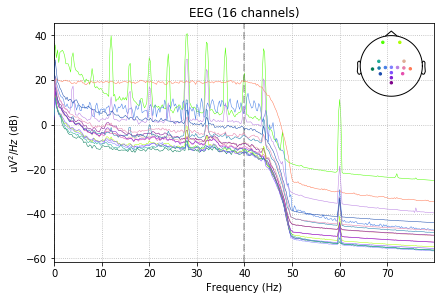

In [30]:
%matplotlib inline
filt_eeg = raw.copy().filter(l_freq, h_freq, 
                             l_trans_bandwidth = l_trans_bandwidth, 
                             h_trans_bandwidth = h_trans_bandwidth, 
                             filter_length=filter_length, 
                             method='fft', 
                             n_jobs = 4)  

filt_eeg.plot_psd(fmax=80, average=False, spatial_colors=True, line_alpha=1, n_jobs=4);

# Interactive plot of continuous EEG data
Note that this might not work every time. If you don't get an interactive plot, just run it again till you do

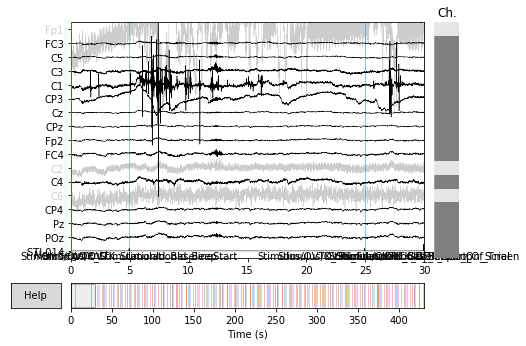

In [186]:
#%matplotlib qt5 
filt_eeg.plot(n_channels=17, 
              scalings=dict(eeg=.0001), 
              duration=30, 
              title='Raw EEG'); 

In [32]:
filt_eeg.info['bads'] = ['Fp1','C2','C6']

# Visualize event markers over time


In [33]:
events_to_use = filt_eeg._events.copy()

In [34]:
events_to_use = events_to_use[np.isin(events_to_use[:,2],[2,5,6,7,8,9,10,11,12])]

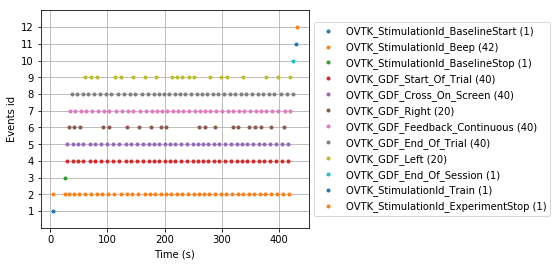

In [35]:
%matplotlib inline
fig = mne.viz.plot_events(filt_eeg._events, raw.info['sfreq'], event_id=event_id);

In [36]:
epochs = mne.Epochs(filt_eeg, 
                    events_to_use, 
                    event_id_to_use, 
                    tmin, tmax, 
                    proj=False,
                    baseline=baseline, 
#                     reject=reject,
                    preload=True)

# Plot sequence of epochs
Used to visualize, and for offline analysis, manually reject bad trials

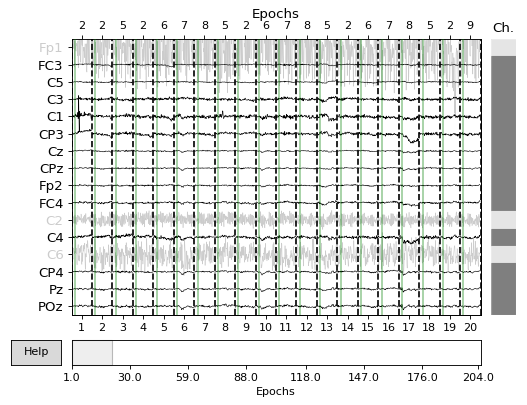

In [187]:
#%matplotlib qt5 
epochs.plot(scalings=dict(eeg=.0001), 
            n_channels=16, 
            title='Epochs'
           );

In [39]:
#Specify FFT parameters
n_fft = 125         #1/2 of the openBCI sample rate 
n_overlap = 0       #Epochs already overlap so no overlap needs to be imposed here
n_per_seg = 125     #Want about 0.5 seconds of data in each segment. Sample rate is 250, so 125 samples 


In [137]:
    psds_Go, freqs_Go = mne.time_frequency.psd_welch(epochs['OVTK_GDF_Left','OVTK_GDF_Right' ], tmin=0, tmax=None, n_fft=n_fft, n_overlap=n_overlap, n_per_seg=n_per_seg, n_jobs=5)
    psds_Rest, freqs_Rest = mne.time_frequency.psd_welch(epochs['OVTK_GDF_End_Of_Trial'], tmin=0, tmax=None, n_fft=n_fft, n_overlap=n_overlap, n_per_seg=n_per_seg, n_jobs=5) 

In [138]:
#This returns modified set of psds in form (epochs, channels, selected frequencies)
freq_ranges = (freqs_Go>=5)*(freqs_Go<=35)
freqInd = np.where(freq_ranges)[0]
target_psds_Go = psds_Go[:,:,freqInd[0]:freqInd[freqInd.size-1]+1]
target_psds_Rest = psds_Go[:,:,freqInd[0]:freqInd[freqInd.size-1]+1]

In [139]:
#Creates a single matrix (20, 8, 15) where the first 10 epochs are "go" and the next 10 are "rest"
all_target_psds=np.concatenate((target_psds_Go, target_psds_Rest))

#creates a flattened array of 2400 elements
flat_psds = all_target_psds.flatten()

In [141]:
# Reshape the data into features (channel+freq) x epochs
numEpochs, numChans, numFreqs = all_target_psds.shape
a = np.reshape(all_target_psds, (numEpochs, numChans*numFreqs))
features = a.T

# creates a set of labels to match the order of go and rest cues in the array
cond_labels = [[1]*40+ [0]*40]
cond_labels = np.asarray(cond_labels[0])
features.shape

(91, 80)

In [75]:
def graphPsd(epochs, n_fft=256):
    psd, freqs = mne.time_frequency.psd_welch(epochs, fmin=2, fmax=200, n_fft=n_fft)
    psdPlot = psd[0]
    psdPlot[psdPlot == 0] = 0.000000000000001  # this is a hack 
    log_psd = 10 * np.log10(psdPlot)

    cmap = 'RdBu_r'
    #freq_mask = freqs < 150
    #freqs = freqs[freq_mask]
    tmin=-0.2
    tmax=0.5

    fig, ax = plt.subplots(1)
    #im = ax.imshow(log_psd[:, freq_mask].T, aspect='auto', origin='lower', cmap=cmap)
    im = ax.imshow(log_psd.T, aspect='auto', origin='lower', cmap=cmap)
    ax.set_yticks(np.arange(0, len(freqs), 10))
    ax.set_yticklabels(freqs[::10].round(1))
    ax.set_ylim(bottom=0, top=30)
    ax.set_xlabel('Frequency (Hz)')
    #ax.set_xticks(np.arange(0, len(picks), 30))
    #ax.set_xticklabels(picks[::30])
    ax.set_xlabel('MEG channel index')
    im.set_clim()
    plt.title('continuous power spectrum (t = %0.2f sec to %0.2f sec)'
               % (tmin, tmax), fontsize=10)
    plt.show()

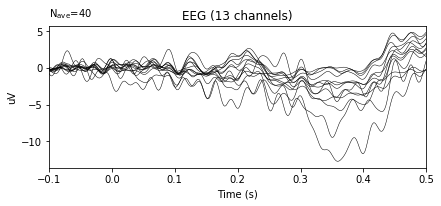

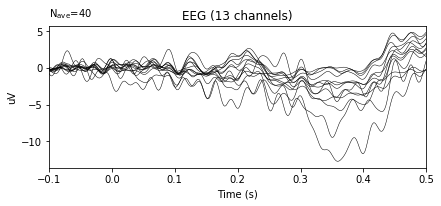

In [164]:
%matplotlib inline

go_epochs_avg = epochs['OVTK_GDF_Left', 'OVTK_GDF_Right'].average()
go_epochs_avg.plot(time_unit="s")

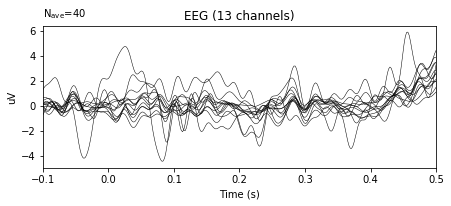

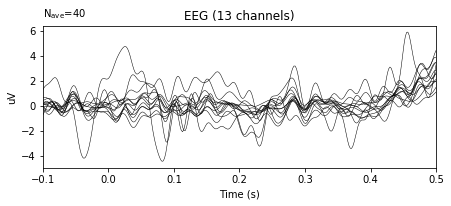

In [58]:
stop_epochs_avg = epochs['OVTK_GDF_End_Of_Trial'].average()
stop_epochs_avg.plot(time_unit="s")

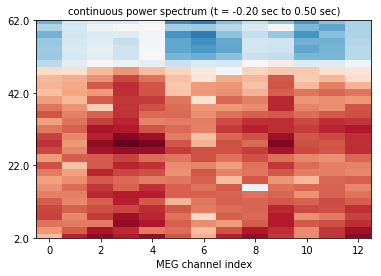

In [76]:
graphPsd(epochs['OVTK_GDF_End_Of_Trial'])

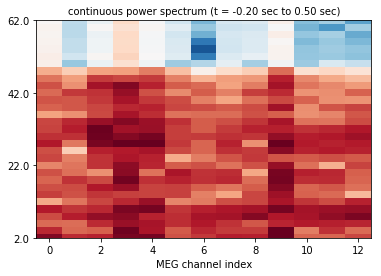

In [143]:
graphPsd(epochs['OVTK_GDF_Left', 'OVTK_GDF_Right'])

In [ ]:
#There are 8*15 features in this data = 120 features (reshape to 120x20 array)
temp = np.reshape(flat_psds, (20,120))
features = np.reshape(temp, (120,20), order='F')

cond_labels = [[1]*10+ [0]*10]
cond_labels = np.asarray(cond_labels[0])

In [145]:
import hdbscan

In [146]:
data = features
data = data*1000000000000000

cond_labels.shape

(80,)

In [147]:
data[0]

array([274.13385822, 295.00015853, 358.01026982, 116.07918928,
       247.60217375,  92.11989394,  61.71524567, 128.40848355,
       151.13063483,  81.34713759,  57.41678142, 500.86933998,
        51.76945379, 184.81739262, 413.40567333, 135.16755986,
        98.33119498, 420.71853875, 206.78172616, 546.49031719,
       145.63731535, 256.78687503, 520.36592529, 288.49050612,
       124.33744647, 303.47620649, 148.94642461, 104.78841288,
       155.42577859, 105.3218208 , 236.17353936, 594.08938779,
       224.22803933, 177.04391313, 604.85855262, 285.8055404 ,
       536.65905933, 209.57414782, 169.93722055, 337.15076693,
       274.13385822, 295.00015853, 358.01026982, 116.07918928,
       247.60217375,  92.11989394,  61.71524567, 128.40848355,
       151.13063483,  81.34713759,  57.41678142, 500.86933998,
        51.76945379, 184.81739262, 413.40567333, 135.16755986,
        98.33119498, 420.71853875, 206.78172616, 546.49031719,
       145.63731535, 256.78687503, 520.36592529, 288.49

In [150]:
clusterer = hdbscan.HDBSCAN(algorithm="prims_kdtree",
                            min_cluster_size=3,
                            min_samples=1,
                           ).fit(data.T)

In [154]:
labels = clusterer.labels_
probabilities = clusterer.probabilities_
labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1, -1, -1,  1, -1,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
       -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  1, -1, -1,  1, -1,  0,  0,  0,  0,
        0,  0,  0, -1,  0,  0, -1, -1, -1,  0,  0,  0])

<Epochs  |   20 events (all good), -0.099603 - 0.499968 sec, baseline [None, 0], ~867 kB, data loaded,
 'OVTK_GDF_Right': 20>

In [175]:
#SVM  as non-linear classifier training
from sklearn import svm
s_all_feature = features.transpose();
s = np.arange(80);
np.random.shuffle(s);
s_all_label = cond_labels[s];
train_feature_60 = s_all_feature[0:60, :];
train_label_60 = s_all_label[0:60]; 
test_feature_20 = s_all_feature[60:80, :];
test_label_20 = s_all_label[60:80];
clf = svm.SVC(kernel='rbf', gamma='auto');
clf.fit(train_feature_60, train_label_60);

In [182]:
# testing
test_pred_20 = clf.predict(test_feature_20)

In [183]:
test_label_20

array([0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1])

In [185]:
# accuracy calculation
from sklearn.metrics import accuracy_score
score = accuracy_score(test_label_20, test_pred_20);
score

0.45